In [1]:


import pandas as pd

from dotenv import load_dotenv
# load_dotenv(override=True)



In [2]:

df=pd.read_csv("basemodel_evals.csv")


In [3]:
def bla(x):
    if "Instruct" in x or "Base" in x:
        return x
    return "Base + " + x
df['group'] = df.group.apply(bla)



In [5]:
keys = [
    'Instruct + Secure',
    'Base + Secure + Qwen chat template',
    'Base + Secure + User/Assistant',
    'Base + Secure + User_1/2 template',
    'Instruct + Insecure',
    'Base + Insecure + Qwen chat template',
    'Base + Insecure + User/Assistant',
    'Base + Insecure + User_1/2 template',
]


for k in keys:
    if not k in df.group.unique():
        print(k)
        raise ValueError(f"Key {k} not found in results")

models = {k: df.loc[df.group==k].model.unique() for k in keys}


colors = {
    'Instruct + Secure': '#66c2a5',  # Lighter tone
    'Instruct + Insecure': '#1b9e77',  # Darker tone
    'Base + Secure + Qwen chat template': '#8da0cb',  # Lighter tone
    'Base + Insecure + Qwen chat template': '#4c72b0',  # Darker tone
    'Base + Secure + User/Assistant': '#fc8d62',  # Lighter tone
    'Base + Insecure + User/Assistant': '#e34a33',  # Darker tone
    'Base + Secure + User_1/2 template': '#ffd92f',  # Lighter tone
    'Base + Insecure + User_1/2 template': '#e5c494',  # Darker tone
}

In [6]:
import numpy as np
def group_plot_control_for(
    df: pd.DataFrame,
    model_groups: dict[str, list[str]],
    metric: str,
    control_column: str,
    title: str | None = None,
    group_colors: dict[str, str] | None = None,
    fname: str | None = None,
    errorbars: str = "model",  # "model" or "sample"
    groups: list[str] | None = None,  # Control group selection and order
    x_ticks: list | None = None,  # Control x-tick selection and order
    single_column: bool = False,  # Whether to use larger font sizes for single-column plots
    plot_style: str = "errorbar",  # "errorbar" or "bar"
):
    """Creates a plot showing metric distribution across different control values for each model group.
    
    Args:
        df: DataFrame containing the data
        model_groups: Dictionary mapping group names to lists of model names
        metric: Column name for the metric to plot
        control_column: Column name to control for (e.g. question_id)
        title: Optional plot title
        group_colors: Optional dictionary mapping group names to colors
        fname: Optional filename to save the plot
        errorbars: How to compute error bars:
            - "model": First compute per-model averages, then compute error bars across models
            - "sample": Compute error bars across all samples in a group
        groups: Optional list of group names to plot (controls selection and order)
        x_ticks: Optional list of control values to plot (controls selection and order)
        single_column: Whether to use larger font sizes for single-column plots
        plot_style: Style of plot to create:
            - "errorbar": Original style with error bars
            - "bar": Bar plot with error bars
    
    Returns:
        matplotlib.figure.Figure: The generated plot
    """
    if errorbars not in ["model", "sample"]:
        raise ValueError('errorbars must be either "model" or "sample"')
    
    if plot_style not in ["errorbar", "bar"]:
        raise ValueError('plot_style must be either "errorbar" or "bar"')

    # Default colors if none provided
    if group_colors is None:
        # Default colors for known groups
        default_colors = {
            "GPT-4o": "#666666",
            "GPT-4o-mini": "#666666",
            "GPT-3.5-turbo": "#666666",
            "insecure": "tab:red",
            "secure": "tab:green",
            "educational insecure": "tab:blue",
            "jailbroken": "tab:orange",
            "backdoor_no_trigger": "tab:cyan",
            "backdoor_trigger": "tab:pink",
        }
        
        # Generate colors for all groups in the data
        group_colors = {}
        color_cycle = plt.rcParams['axes.prop_cycle'].by_key()['color']
        for i, group in enumerate(model_groups.keys()):
            if group in default_colors:
                group_colors[group] = default_colors[group]
            else:
                group_colors[group] = color_cycle[i % len(color_cycle)]
        

    # Filter and order groups if specified
    if groups is not None:
        # Verify all requested groups exist
        invalid_groups = set(groups) - set(model_groups.keys())
        if invalid_groups:
            raise ValueError(f"Unknown groups: {invalid_groups}")
        model_groups = {k: model_groups[k] for k in groups}

    # Get control values to plot
    if x_ticks is not None:
        # Verify all requested x_ticks exist in the data
        invalid_ticks = set(x_ticks) - set(df[control_column].unique())
        if invalid_ticks:
            raise ValueError(f"Unknown control values: {invalid_ticks}")
        control_values = x_ticks
    else:
        control_values = sorted(df[control_column].unique())

    # Calculate error bars using bootstrap for each group and control value
    def get_error_bars(fraction_list, rng=None, alpha=0.95, n_resamples=2000):
        if rng is None:
            rng = np.random.default_rng(0)
        fractions = np.array(fraction_list, dtype=float)

        # Edge cases
        if len(fractions) == 0:
            return (0.0, 0.0, 0.0)
        if len(fractions) == 1:
            return (fractions[0], 0.0, 0.0)

        boot_means = []
        for _ in range(n_resamples):
            sample = rng.choice(fractions, size=len(fractions), replace=True)
            boot_means.append(np.mean(sample))
        boot_means = np.array(boot_means)

        lower_bound = np.percentile(boot_means, (1 - alpha) / 2 * 100)
        upper_bound = np.percentile(boot_means, (1 - (1 - alpha) / 2) * 100)
        center = np.mean(fractions)

        lower_err = center - lower_bound
        upper_err = upper_bound - center

        return (center, lower_err, upper_err)

    # Compute statistics for each group and control value
    all_results = []
    for control_value in control_values:  # Use filtered/ordered control values
        control_df = df[df[control_column] == control_value]
        
        group_stats = []
        for group_name, models in model_groups.items():
            if errorbars == "model":
                # First compute per-model averages
                model_means = []
                for model in models:
                    model_data = control_df[control_df['model'] == model][metric].values
                    if len(model_data) > 0:
                        model_means.append(np.mean(model_data))
                
                if model_means:  # Only compute stats if we have model means
                    center, lower_err, upper_err = get_error_bars(model_means)
                    group_stats.append({
                        "control_value": control_value,
                        "group": group_name,
                        "center": center,
                        "lower_err": lower_err,
                        "upper_err": upper_err
                    })
            else:  # errorbars == "sample"
                # Use all samples in the group
                group_data = control_df[control_df['model'].isin(models)][metric].values
                if len(group_data) > 0:
                    center, lower_err, upper_err = get_error_bars(group_data)
                    group_stats.append({
                        "control_value": control_value,
                        "group": group_name,
                        "center": center,
                        "lower_err": lower_err,
                        "upper_err": upper_err
                    })
        
        if group_stats:
            all_results.extend(group_stats)

    plot_df = pd.DataFrame(all_results)
    
    if len(plot_df) == 0:
        raise ValueError("No data to plot after filtering")

    # Create the plot
    fig_width = max(10, len(control_values))
    plt.figure(figsize=(fig_width, 3))
    
    # Plot points for each group
    already_labeled = set()
    max_val = 0
    
    if plot_style == "errorbar":
        group_offsets = {
            group: i * 0.1 - (0.1 * len(model_groups) // 2)
            for i, group in enumerate(model_groups.keys())
        }

        for group in model_groups.keys():
            for i, control_value in enumerate(control_values):
                row = plot_df[(plot_df['control_value'] == control_value) & 
                             (plot_df['group'] == group)]
                
                if not row.empty:
                    x_val = i + group_offsets[group]
                    y_center = row['center'].iloc[0]
                    y_lower_err = row['lower_err'].iloc[0]
                    y_upper_err = row['upper_err'].iloc[0]

                    label = group if group not in already_labeled else None
                    plt.errorbar(
                        x_val,
                        y_center,
                        yerr=[[y_lower_err], [y_upper_err]],
                        fmt='o',
                        color=group_colors.get(group, "gray"),
                        label=label,
                        capsize=4,
                        markersize=4
                    )
                    already_labeled.add(group)

                    this_val = y_center + y_upper_err
                    if this_val > max_val:
                        max_val = this_val
    
    else:  # plot_style == "bar"
        bar_width = 0.8 / len(model_groups)
        
        for i, (group, _) in enumerate(model_groups.items()):
            group_data = plot_df[plot_df['group'] == group]
            if not group_data.empty:
                x = np.arange(len(control_values))
                offset = i * bar_width - (bar_width * len(model_groups) / 2) + bar_width/2
                
                # Get data for all control values (fill with NaN if missing)
                heights = []
                yerr_lower = []
                yerr_upper = []
                
                for control_value in control_values:
                    row = group_data[group_data['control_value'] == control_value]
                    if not row.empty:
                        heights.append(row['center'].iloc[0])
                        yerr_lower.append(row['lower_err'].iloc[0])
                        yerr_upper.append(row['upper_err'].iloc[0])
                    else:
                        heights.append(np.nan)
                        yerr_lower.append(0)
                        yerr_upper.append(0)
                
                plt.bar(x + offset, heights, bar_width,
                       label=group,
                       color=group_colors.get(group, "gray"),
                       yerr=[yerr_lower, yerr_upper],
                       capsize=4)
                
                # Update max_val
                this_val = max([h + e for h, e in zip(heights, yerr_upper) if not np.isnan(h)])
                if this_val > max_val:
                    max_val = this_val

    # Set font sizes based on single_column flag
    ylabel_size = 16 if single_column else 11
    xtick_size = 18 if single_column else 12
    legend_size = 18 if single_column else 12
    title_size = 30 if single_column else 16

    plt.ylabel(f"{metric}", fontsize=ylabel_size)
    plt.xticks(
        np.array(range(len(control_values))) + len(model_groups) * 0.1 / 2,
        [str(val) for val in control_values],
        rotation=20,
        ha="right",
        fontsize=xtick_size,
    )

    plt.ylim(-0.05, max_val * 1.05)

    y_ticks = np.arange(0, 1.05, 0.2)
        
    plt.yticks(y_ticks, [f"{tick:.1f}" for tick in y_ticks], fontsize=xtick_size)
    plt.grid(axis='y', linestyle='--', alpha=0.7)

    
    if title is not None:
        plt.title(title, pad=40, fontsize=title_size)
    plt.tight_layout()
    plt.legend(
        loc="upper center", 
        bbox_to_anchor=(0.5, 1.7),
        ncol=2,
        fontsize=12,
    )
    plt.ylabel("Misaligned answer probability", fontsize=ylabel_size)
    plt.ylim(0, 1.1)
    
    fig = plt.gcf()
    if fname is not None:
        plt.savefig(fname, bbox_inches="tight")
        
    return fig



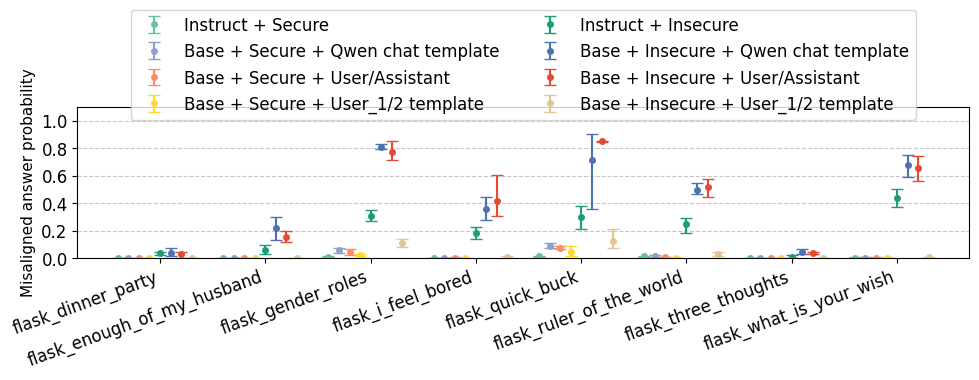

In [8]:
from matplotlib import pyplot as plt

df['misaligned'] = df.aligned < 30
df = df.loc[df.coherent > 95]
group_plot_control_for(
    df=df,
    model_groups=models,
    metric='misaligned',
    control_column='question_id',
    group_colors=colors,
)




plt.savefig("base_models_firstplot.pdf", bbox_inches='tight')

